# Simple Classifier

In [42]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import itertools

## Functions

In [62]:
def readTxtFile(filename):
    return [line.rstrip("\n") for line in open(filename)]

def genKey(author, coauthor):
    if author < coauthor: return str(author) + '-' + str(coauthor)
    else: return str(coauthor) + '-' + str(author)

def createEdgeListGraph(dataRow):
    dictionary = {}
    for row in dataRow:
        authorIds = [int(i) for i in row.split()]
        authorIds.sort()
        for i, author in enumerate(authorIds):
            for coauthor in authorIds[i+1:]:
                key = genKey(author,coauthor)
                if key in dictionary:
                    dictionary[key] = dictionary[key] + 1
                else:
                    dictionary[key] = 1
    return dictionary

def loadTestData(filename):
    return pd.read_csv(filename)

#network graph drawing

def createG1(txt):
    txt = []
    with open("train.txt") as f:
        l = f.readline()
        while l:
            txt.append(list(map(int,l.split())))
            l = f.readline()
            
    g1 = {}
    converted_txt = []
    
    for link in txt:
        for subset in itertools.permutations(link, 2):
            converted_txt.append(subset)
    train1 = pd.DataFrame(converted_txt, columns = ["srce", "dest"])
    freq = train1.groupby(["srce", "dest"]).size().values 
    txt_1 = sorted(set(converted_txt))
    for points, f in zip (txt_1, freq):
        g1[points[0]] = g1.setdefault(points[0], [])
        g1[points[0]].append((points[1], 1/f))
        
    return g1

# path finding
def find_min(g1, open_dict, close_dict, sink):
    values = list(open_dict.values())
    values.sort(key = lambda x: x[1])
    min = values[0][0]
    for i in open_dict.keys():
        if open_dict[i][0] == min:
            return [i, open_dict[i][0], open_dict[i][1]]

def show_path(close_dict, path, sink):
    if (sink in close_dict.keys()):
        path.append(sink)
        path = show_path(close_dict, path, close_dict[sink][1])
    return path

"""
path finding algorithms. open_dict stores all visible nodes, close_dict stores all nodes that we 
have traversed. it does so in the following steps:
        1. initialization: put start node (srce:[cost to this node, its parent node]) in open_dict.
                        let close_dict empty.
        2. if open_dict is empty, return empty path, otherwise keep taken lowest cost path from 
        open_dict to close_dict.
        3. if min_key[0] is sink, then return a optimal path, else expand subnode of min_key[0]
        for each subnode:
            if in close_dict, ignore it.
            if not in open_dict, calculate its cost, and parent node, put them in open_dict.
            if in open_dict, update its minimum cost.
        4. go to step 2.

"""    
def find_path(g1, srce, sink):
    path = []
    open_dict = {srce:[0, -1]}
    close_dict = {}
    while len(open_dict.keys()) != 0:
        min_key = find_min(g1, open_dict, close_dict, sink)
        close_dict[min_key[0]] = [min_key[1], min_key[2]] # [score, parent node]
        if min_key[0] == sink:
            return show_path(close_dict, path, sink)[::-1]
        else:
            subnodes = []
            if min_key[0] not in g1.keys():
                open_dict.pop(min_key[0])
                continue
            for i in g1[min_key[0]]:
                subnodes.append([i[0], i[1], min_key[0]]) #[current, score, parent node]
            for node in subnodes:
                if node[0] in close_dict.keys():
                    continue
                if node[0] not in open_dict.keys():
                    open_dict[node[0]] = [node[1], node[2]]
                elif node[0] in open_dict.keys():
                    if open_dict[node[0]][0] > node[1]:
                        open_dict[node[0]][0] = node[1]
                        open_dict[node[0]][1] = node[2]
            open_dict.pop(min_key[0])
    return []

def cal_score(g1, path):
    s = 0
    for i in range(len(path) - 1):
        for j in g1[path[i]]:
            if j[0] == path[i + 1]:
                s += j[1]
    return s

## Classify and Predict

In [39]:
import math
import numpy as np
def activationFunction(freq, minF, maxF):
    return (freq - minF)/ (maxF - minF) # Normalise between 0-1

def predict(classifier, author, coauthor):
    key = genKey(author, coauthor)
    if key in classifier:
        return classifier[key]
    else:
        return 0

# Load data
train = readTxtFile("train.txt")
test = loadTestData('test-public.csv')

# Preprocess data
trainGraph = createEdgeListGraph(train)
# Create simple classifier
simpleClassifier = {}
for (key, freq) in trainGraph.items():
    simpleClassifier[key] = activationFunction(freq, 0, 45)

# Predict data
test['Predicted'] = test.apply(lambda i: predict(simpleClassifier, i.Source, i.Sink), axis=1)

# Save result
test[['Id', 'Predicted']].to_csv('results/simpleClassifierPredicted.csv', index=False)


## Evaluate

In [82]:
sample = pd.read_csv('sample.csv')
yTrue = sample[['Predicted']]
yPred = test[['Predicted']]
print('MSE = ', mean_squared_error(yTrue, yPred))

MSE =  0.30496710657330284


In [64]:
# Load data
test = loadTestData('test-public.csv')

# Load and Preprocess data
G1 = createG1(train)

# Predict data
results = []
for idx, i in test.iterrows():
    path = find_path(G1, i[1], i[2])
    #print(idx, path)
    if len(path) == 0:
        results.append(0)
    else:
        results.append(cal_score(G1, path))


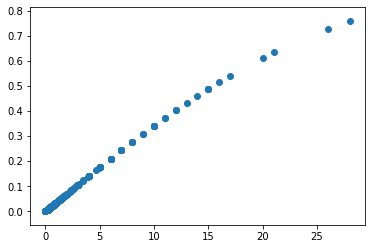

In [91]:
import matplotlib.pyplot as plt

plt.scatter(mod, yPred)

In [93]:
X_train = np.array(mod)
y_train = yPred
XTX = np.dot(X_train.T, X_train)
XTy = np.dot(X_train.T, y_train)

In [96]:
from sklearn.linear_model import LinearRegression
X_train_b = np.column_stack((np.ones_like(X_train), X_train))
lr_full = LinearRegression().fit(X_train_b, y_train)
y_pred_train = lr_full.predict(X_train_b)


In [98]:
print('MSE = ', mean_squared_error(y_pred_train, yPred))

MSE =  2.8731727894963782e-05


In [99]:
test['Predicted'] = y_pred_train

In [100]:
test[['Id', 'Predicted']].to_csv('results/simpleClassifierPredicted.csv', index=False)